In [ ]:
!pip -q install kaggle

## Download Kaggle Dataset

In [ ]:
!rm -rf horses-or-humans-dataset/

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download sanikamal/horses-or-humans-dataset

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                        Student Performance Factors                          94KB  2024-09-02 10:53:57          25729        454  1.0              
ironwolf404/electric-vehicle-population-in-usa                 Electric Vehicle Population in USA                    6MB  2024-10-05 12:06:02            771         25  1.0              
abdulszz/spotify-most-streamed-songs                           Spotify Most Streamed Songs                          60KB  2024-09-07 18:23:14           9385        124  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset    Mo

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
torch.__version__

'2.4.1+cu121'

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
from pathlib import Path
import zipfile

data_path = Path('/content/')
image_path = data_path / 'horses-or-humans-dataset'

with zipfile.ZipFile(data_path / 'horses-or-humans-dataset.zip', 'r') as zip_ref:
    print('Unzipping dataset')
    zip_ref.extractall(image_path)

Unzipping dataset


In [ ]:
walk_through_dir(image_path)

There are 1 directories and 0 images in '/content/horses-or-humans-dataset'.
There are 2 directories and 0 images in '/content/horses-or-humans-dataset/horse-or-human'.
There are 2 directories and 0 images in '/content/horses-or-humans-dataset/horse-or-human/validation'.
There are 0 directories and 128 images in '/content/horses-or-humans-dataset/horse-or-human/validation/humans'.
There are 0 directories and 128 images in '/content/horses-or-humans-dataset/horse-or-human/validation/horses'.
There are 2 directories and 0 images in '/content/horses-or-humans-dataset/horse-or-human/train'.
There are 0 directories and 527 images in '/content/horses-or-humans-dataset/horse-or-human/train/humans'.
There are 0 directories and 500 images in '/content/horses-or-humans-dataset/horse-or-human/train/horses'.


In [ ]:
!rm -rf /content/horses-or-humans-dataset/horse-or-human/horse-or-human

In [ ]:
train_dir = image_path / 'horse-or-human' / 'train'
test_dir = image_path / 'horse-or-human' / 'validation'

train_dir, test_dir

(PosixPath('/content/horses-or-humans-dataset/horse-or-human/train'),
 PosixPath('/content/horses-or-humans-dataset/horse-or-human/validation'))

Random Image Path : /content/horses-or-humans-dataset/horse-or-human/train/horses/horse39-1.png
Image Class : horses
Image Height : 300 and Width : 300


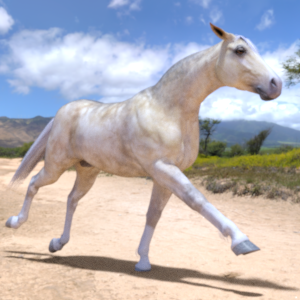

In [ ]:
# pick a random image for checking
import random
from PIL import Image

image_path_list = list(image_path.glob('*/*/*/*.png'))

# pick a random image
random_image_path = random.choice(image_path_list)

# get class image from pathname
image_class = random_image_path.parent.stem

# open images
img = Image.open(random_image_path)

# print the metadata
print(f'Random Image Path : {random_image_path}')
print(f'Image Class : {image_class}')
print(f'Image Height : {img.height} and Width : {img.width}')
img

## Transforming Data

In [ ]:
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
train_transform = v2.Compose([
    v2.Resize(size=(224,224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

test_transform = v2.Compose([
    v2.Resize(size=(224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [ ]:
from helper_functions import plot_transformed_images

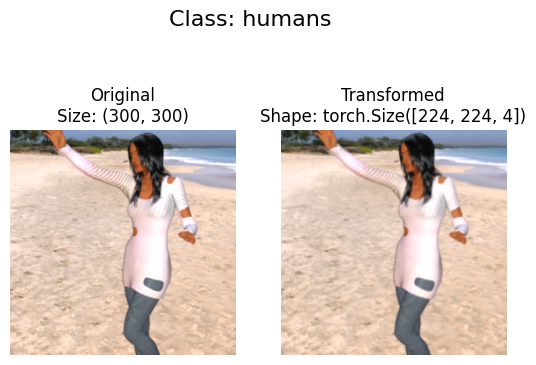

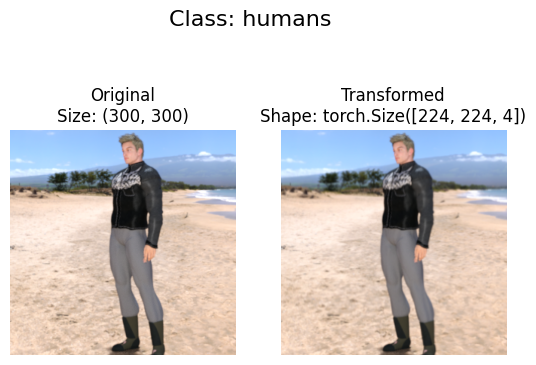

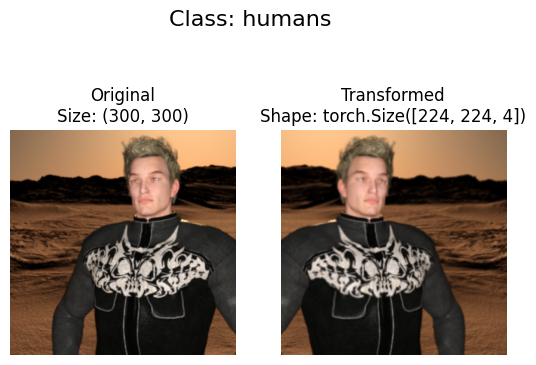

In [ ]:
plot_transformed_images(image_paths=image_path_list, transform=train_transform)

## Load dataset

In [ ]:
train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=train_transform,
                                     target_transform=None)

test_dataset = datasets.ImageFolder(root=test_dir,
                                    transform=test_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 1027
     Root location: /content/horses-or-humans-dataset/horse-or-human/train
     StandardTransform
 Transform: Compose(
                  Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToImage()
                  ToDtype(scale=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 256
     Root location: /content/horses-or-humans-dataset/horse-or-human/validation
     StandardTransform
 Transform: Compose(
                  Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToImage()
                  ToDtype(scale=True)
            ))

In [ ]:
class_names = train_dataset.classes
class_names

['horses', 'humans']

In [ ]:
class_dict = train_dataset.class_to_idx
class_dict

{'horses': 0, 'humans': 1}

In [ ]:
len(train_dataset), len(test_dataset)

(1027, 256)

In [ ]:
BATCH_SIZE = 32
CPU_WORKER = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=CPU_WORKER)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=CPU_WORKER)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78b0c1d140d0>,
 <torch.utils.data.dataloader.DataLoader at 0x78b0c1cff820>)

In [ ]:
from torch import nn

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(input_layer, hidden_layer,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(hidden_layer, hidden_layer,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(hidden_layer,hidden_layer,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(hidden_layer, hidden_layer,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(hidden_layer,hidden_layer,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(hidden_layer,hidden_layer,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_layer*24*24, output_layer),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model_test = TinyVGG(
    input_layer=3,
    hidden_layer=8,
    output_layer=len(class_names)
).to(device)

model_test

TinyVGG(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=2, bias=True)
    (2): Sigmoid()
  )
)

In [ ]:
# Create dummy input

dummy = torch.randn(size=(1, 3, 224, 224)).to(device)

model_test.eval()
with torch.inference_mode():
    print(model_test(dummy))

tensor([[0.5125, 0.5094]], device='cuda:0')


In [ ]:
!pip -q install torchinfo

In [ ]:
from torchinfo import summary

summary(model_test, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 2]                   --
├─Sequential: 1-1                        [32, 8, 110, 110]         --
│    └─Conv2d: 2-1                       [32, 8, 222, 222]         224
│    └─ReLU: 2-2                         [32, 8, 222, 222]         --
│    └─Conv2d: 2-3                       [32, 8, 220, 220]         584
│    └─ReLU: 2-4                         [32, 8, 220, 220]         --
│    └─MaxPool2d: 2-5                    [32, 8, 110, 110]         --
├─Sequential: 1-2                        [32, 8, 53, 53]           --
│    └─Conv2d: 2-6                       [32, 8, 108, 108]         584
│    └─ReLU: 2-7                         [32, 8, 108, 108]         --
│    └─Conv2d: 2-8                       [32, 8, 106, 106]         584
│    └─ReLU: 2-9                         [32, 8, 106, 106]         --
│    └─MaxPool2d: 2-10                   [32, 8, 53, 53]           --
├─Sequentia

In [ ]:
# train test function
import torch
from torch import nn
from tqdm.auto import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    y = y.unsqueeze(1).float()

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)
      y = y.unsqueeze(1).float()

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

In [ ]:
# training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_layer=3,
                  hidden_layer=16,
                  output_layer=1).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_function,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6954 | train_acc: 15.1515 | test_loss: 0.6902 | test_acc: 16.0000
Epoch: 2 | train_loss: 0.6232 | train_acc: 15.1515 | test_loss: 0.5887 | test_acc: 16.0000
Epoch: 3 | train_loss: 0.5840 | train_acc: 15.1515 | test_loss: 0.6593 | test_acc: 16.0000
Epoch: 4 | train_loss: 0.6039 | train_acc: 15.1515 | test_loss: 0.5830 | test_acc: 16.0000
Epoch: 5 | train_loss: 0.5824 | train_acc: 15.1515 | test_loss: 0.5844 | test_acc: 16.0000
Epoch: 6 | train_loss: 0.5759 | train_acc: 15.1515 | test_loss: 0.5425 | test_acc: 16.0000
Epoch: 7 | train_loss: 0.5810 | train_acc: 15.1515 | test_loss: 0.5773 | test_acc: 16.0000
Epoch: 8 | train_loss: 0.5802 | train_acc: 15.1515 | test_loss: 0.5772 | test_acc: 16.0000
Epoch: 9 | train_loss: 0.5888 | train_acc: 15.1515 | test_loss: 0.5710 | test_acc: 16.0000
Epoch: 10 | train_loss: 0.6015 | train_acc: 15.1515 | test_loss: 0.5777 | test_acc: 16.0000
Epoch: 11 | train_loss: 0.5827 | train_acc: 15.1515 | test_loss: 0.5634 | test_acc: 16.00

## Model needs work even more